# Sprint5 機械学習スクラッチ SVM

SVM（サポートベクターマシン）をスクラッチする。SVMは分類と回帰の双方に使用できるが、今回は分類のみを扱う。

また、カーネルは線形、マージンはハードマージンを扱う。



In [1]:
#基本ライブラリ
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

## 具体的な理解


In [36]:
#サンプルデータ
X = np.array([[1,1],[5,4], [1,2], [3,4], [2,1], [2,2], [4,3], [5,3]])
y = np.array([1, -1, 1, -1, 1, 1, -1, -1])

#ラグランジュ乗数を初期化
lagrange = np.full(X.shape[0], 0.5)

#バイアス項
bias_term = np.ones(X.shape[0]).reshape(X.shape[0],1)
X = np.concatenate([bias_term, X], 1)

df = pd.DataFrame(np.concatenate([X, y.reshape(8,1)], 1), columns=["b", "x1", "x2", "y"])
df

,b,x1,x2,y
0,1.0,1.0,1.0,1.0
1,1.0,5.0,4.0,-1.0
2,1.0,1.0,2.0,1.0
3,1.0,3.0,4.0,-1.0
4,1.0,2.0,1.0,1.0
5,1.0,2.0,2.0,1.0
6,1.0,4.0,3.0,-1.0
7,1.0,5.0,3.0,-1.0


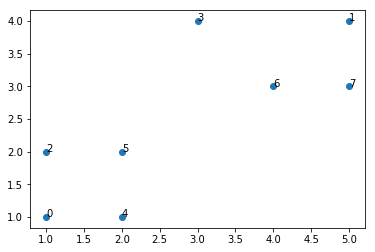

In [37]:
plt.scatter(df.x1, df.x2)
for i, txt in enumerate(df.index.values):
    plt.annotate(txt, (df.x1.values[i], df.x2.values[i]))
plt.show()

うまくいけば、「５、６、３」あたりがサポートベクターになる想定

In [38]:
#カーネル関数
x1 = X[0]
x2 = X[1]
k1 = np.dot(x1.T, x2) # 1x1 + 1x5 + 1x4
k2 = np.dot(x1, x2.T) # 1x1 + 1x5 + 1x4
print("x1.T, x2=",k1)
print("x1, x2.T=",k2)

x1.T, x2= 10.0
x1, x2.T= 10.0


1サンプルづつ処理するならば転置の順番は関係ない

In [48]:
#x0のカーネル関数をfor文で作る
for j in range(X.shape[0]):
    x1_list = np.array([])
    for i in range(X.shape[0]):
        x1_list = np.append(x1_list, np.dot(X[j].T, X[i]))
    print(x1_list)



[ 3. 10.  4.  8.  4.  5.  8.  9.]
[10. 42. 14. 32. 15. 19. 33. 38.]
[ 4. 14.  6. 12.  5.  7. 11. 12.]
[ 8. 32. 12. 26. 11. 15. 25. 28.]
[ 4. 15.  5. 11.  6.  7. 12. 14.]
[ 5. 19.  7. 15.  7.  9. 15. 17.]
[ 8. 33. 11. 25. 12. 15. 26. 30.]
[ 9. 38. 12. 28. 14. 17. 30. 35.]


In [45]:
#x0のカーネル関数をnumpyのbroadcastで作る
np.dot(X, X.T)

array([[ 3., 10.,  4.,  8.,  4.,  5.,  8.,  9.],
       [10., 42., 14., 32., 15., 19., 33., 38.],
       [ 4., 14.,  6., 12.,  5.,  7., 11., 12.],
       [ 8., 32., 12., 26., 11., 15., 25., 28.],
       [ 4., 15.,  5., 11.,  6.,  7., 12., 14.],
       [ 5., 19.,  7., 15.,  7.,  9., 15., 17.],
       [ 8., 33., 11., 25., 12., 15., 26., 30.],
       [ 9., 38., 12., 28., 14., 17., 30., 35.]])

In [6]:
#シグマの中身
yjk = y * x1_list
sigma = lagrange * y * x1_list
sigma2 = sigma * y[0]
sum_sigma = np.sum(sigma2)

print("y                     =",y)
print("yj * k(xi, xj)      =", yjk)
print("          ")
print("λ * yj * k(xi, xj)=", sigma)
print("          ")
print("さらにyiを掛ける=", sigma2)
print("y0 = ", y[0])
print("          ")
print("シグマの中身を足す=", sum_sigma)

y                     = [ 1 -1  1 -1  1  1 -1 -1]
yj * k(xi, xj)      = [  3. -10.   4.  -8.   4.   5.  -8.  -9.]
          
λ * yj * k(xi, xj)= [ 1.5 -5.   2.  -4.   2.   2.5 -4.  -4.5]
          
さらにyiを掛ける= [ 1.5 -5.   2.  -4.   2.   2.5 -4.  -4.5]
y0 =  1
          
シグマの中身を足す= -9.5


In [7]:
#ラムダの更新
print("1- sum_sigma =", 1- sum_sigma)
print("学習率掛ける   ＝", 0.1*(1- sum_sigma))
print("old λ=", lagrange[0])
lagrange[0] = lagrange[0] + 0.1*(1- sum_sigma)
print("new λ=", lagrange[0])

1- sum_sigma = 10.5
学習率掛ける   ＝ 1.05
old λ= 0.5
new λ= 1.55


これを全てのλについて行う

## 【問題1】SVM分類機のクラスを作成する

SVM分類器のクラスを作成し、Sprint２で作成した分類のパイプラインに組み込む。

In [21]:
class ScratchSVMClassifier():
    """
    SVMのスクラッチ実装

    Parameters
    ----------
    num_iter : int　イテレーション数
    lr : float　　　　学習率
    no_bias : bool　バイアス項を入れない場合はTrue
    verbose : bool  学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)　パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)　      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)    検証用データに対する損失の記録
    """

    def __init__(self,
                 num_iter=10000,
                 lr=0.001,
                 bias=False,
                 verbose=False,
                 kernel="linear",    #線形カーネル
                 C=1e10,              #ハードマージン
                 threshold=2e-5
                ):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose
        self.kernel = kernel
        self.threshold = threshold
        #ラグランジュ乗数
        self.lagrange = np.array([])
        self.C = C
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        線形回帰を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)        学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )　　　　            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)   検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )　　            検証用データの正解値
        """
        #サンプル数取得
        smpl_num = X.shape[0]
        
        #バイアス項の生成
        if not self.bias:
            bias_term = np.ones(smpl_num).reshape(smpl_num,1)
            X = np.concatenate([bias_term, X], 1)
        
        #λの初期値
        self.lagrange = np.full(smpl_num, np.random.rand())
        #print("λ初期値=", self.lagrange)
        
        #カーネル関数の生成
        kX = self.kernel_funk(X)
        #print("kX=", kX)
        
        #確認用　λリスト
        self.lagrange_list1 = np.array([])
        self.lagrange_list2 = np.array([])
        self.lagrange_list3 = np.array([])
        self.lagrange_list4 = np.array([])
        
        #λ更新
        for _ in range(self.iter):
            #print(self.lagrange)
            for i in range(smpl_num):
                lagrange_tmp = np.copy(self.lagrange)    #更新前のλコピー
                self.lagrange[i] += self.lr*(1 - np.sum((lagrange_tmp * y * kX[i])*y[i]))

                #制約条件
                if self.lagrange[i] < 0:
                    self.lagrange[i] = 0    #λが０より小さい場合は０を代入
                
                    
            self.lagrange_list1 = np.append(self.lagrange_list1, self.lagrange[0])
            self.lagrange_list2 = np.append(self.lagrange_list2, self.lagrange[1])
            self.lagrange_list3 = np.append(self.lagrange_list3, self.lagrange[2])
            self.lagrange_list4 = np.append(self.lagrange_list4, self.lagrange[3])
        
        #サポートベクター
        self.bector_index = []   #ndarrayで作るとスライスのリスト指定のところで面倒
        for i in range(smpl_num):
            if self.lagrange[i] > self.threshold:
                self.bector_index.append(i)
        
        #推定に使用するベクトル
        self.lagrange_s_ = self.lagrange[self.bector_index]
        self.yn_ = y[self.bector_index]
        self.sn_ = X[self.bector_index]
        
                
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()


    def predict(self, X_test):
        """
        線形回帰を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)     サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)      線形回帰による推定結果
        """
        #サンプル数取得
        smpl_num = X_test.shape[0]
        
        #バイアス項の生成
        if not self.bias:
            bias_term = np.ones(smpl_num).reshape(smpl_num,1)
            X_test = np.concatenate([bias_term, X_test], 1)
        
        #推定
        self.y_hat_raw = np.sum(self.lagrange_s_*self.yn_*np.dot(X_test, self.sn_.T), axis=1)
        
        #推定値の変換
        f = lambda x: 1 if x >= 0 else -1
        vf = np.vectorize(f)
        y_hat = vf(self.y_hat_raw)
        
        return y_hat
    
    def kernel_funk(self, X):
        """
        カーネル関数。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, n_samples)
            カーネル関数
        """
        k = np.empty((0,X.shape[0]), float)       #カーネル関数雛形
        
        for i in range(X.shape[0]):                   #Xiイテレーション
            temp = np.array([])                          #ドット積一時保持
            
            for j in range(X.shape[0]):              #Xjイテレーション
                temp = np.append(temp, np.dot(X[i].T, X[j]))

            k = np.append(k, temp.reshape(1, X.shape[0]), axis=0)
        
        return k


In [60]:
#テスト
np.random.seed(seed=32)

X = np.array([[1,1],[5,4], [1,2], [3,4], [2,1], [2,2], [4,3], [5,3]])
y = np.array([1, -1, 1, -1, 1, 1, -1, -1])

import time
t0 = time.time()
for _ in range(10):   #処理時間の平均をとる
    SVM = ScratchSVMClassifier()
    SVM.fit(X, y)
t1 = time.time()
print('time : {}s'.format((t1-t0)/10))

time : 1.214981770515442s


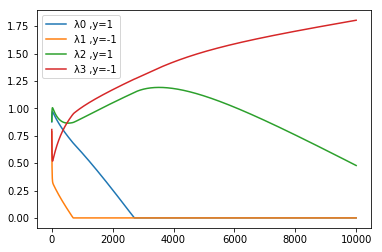

In [10]:
plt.plot(SVM.lagrange_list1, label="λ0 ,y=1")
plt.plot(SVM.lagrange_list2, label="λ1 ,y=-1")
plt.plot(SVM.lagrange_list3, label="λ2 ,y=1")
plt.plot(SVM.lagrange_list4, label="λ3 ,y=-1")
plt.legend()
plt.show()

### 推定

In [11]:
#fitした変数の中身を確認してみる
print("λ=", SVM.lagrange)
print(" ")
print("サポートベクターのindex=", SVM.bector_index)
print(" ")
print("λ_n", SVM.lagrange_s_)
print(" ")
print("y_n=", SVM.yn_)
print(" ")
print("s_n=", SVM.sn_)


λ= [0.         0.         0.47836707 1.80395599 0.50409447 5.36212712
 1.83057182 0.        ]
 
サポートベクターのindex= [2, 3, 4, 5, 6]
 
λ_n [0.47836707 1.80395599 0.50409447 5.36212712 1.83057182]
 
y_n= [ 1 -1  1  1 -1]
 
s_n= [[1. 1. 2.]
 [1. 3. 4.]
 [1. 2. 1.]
 [1. 2. 2.]
 [1. 4. 3.]]


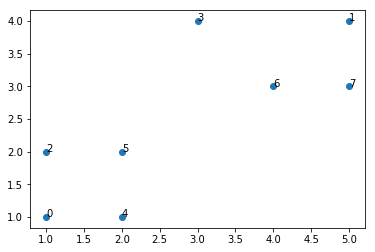

In [12]:
plt.scatter(df.x1, df.x2)
for i, txt in enumerate(df.index.values):
    plt.annotate(txt, (df.x1.values[i], df.x2.values[i]))
plt.show()

サポートベクターのindexが 「2, 3, 4, 5, 6」と推定されたので、図と比べてもまあまあの結果となった。

In [13]:
#推定の処理の流れを確認してみる

#テストデータ
X_test = np.array([[1,1.5, 1.5],[1,4, 4],[1,4,2]])
y_test = np.array([1,-1,-1])

print(np.dot(X_test, SVM.sn_.T))
print("  ")
print(SVM.yn_*np.dot(X_test, SVM.sn_.T))
print("  ")
print(SVM.lagrange_s_*SVM.yn_*np.dot(X_test, SVM.sn_.T))
print("  ")
print("推定値=", np.sum(SVM.lagrange_s_*SVM.yn_*np.dot(X_test, SVM.sn_.T), axis=1))


[[ 5.5 11.5  5.5  7.  11.5]
 [13.  29.  13.  17.  29. ]
 [ 9.  21.  11.  13.  23. ]]
  
[[  5.5 -11.5   5.5   7.  -11.5]
 [ 13.  -29.   13.   17.  -29. ]
 [  9.  -21.   11.   13.  -23. ]]
  
[[  2.63101886 -20.74549388   2.77251956  37.53488981 -21.05157593]
 [  6.21877186 -52.31472369   6.55322805  91.15616098 -53.08658277]
 [  4.3053036  -37.88307578   5.54503912  69.70765251 -42.10315185]]
  
推定値= [ 1.14135843 -1.47314557 -0.4282324 ]


In [14]:
#Scratchクラスのメソッドで動作確認
X_test = np.array([[1.5, 1.5],[4, 4],[4,2]])

y_pred = SVM.predict(X_test)
print(y_pred)

[ 1 -1 -1]


手計算と同じ結果が予測された！！

### 更新式でforを使わないバージョンのクラス

In [68]:
class ScratchSVMClassifier2():
    """
    SVMのスクラッチ実装　更新式をよりシンプルにしたバージョン

    Parameters
    ----------
    num_iter : int　　イテレーション数
    lr : float　　　      学習率
    no_bias : bool      バイアス項を入れない場合はTrue
    verbose : bool     学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : ndarray, shape (n_features,)  パラメータ
    self.loss : ndarray, shape (self.iter,) 　     学習用データに対する損失の記録
    self.val_loss : ndarray, shape (self.iter,)    検証用データに対する損失の記録
    """

    def __init__(self,
                 num_iter=10000,
                 lr=0.001,
                 bias=False,
                 verbose=False,
                 kernel="linear",    #線形カーネル
                 C=1e10,              #ハードマージン
                 threshold=2e-5
                ):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose
        self.kernel = kernel
        self.threshold = threshold
        #ラグランジュ乗数
        self.lagrange = np.array([])
        self.C = C
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        線形回帰を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)           学習用データの特徴量
        y : ndarray, shape (n_samples, )　　　　　            学習用データの正解値
        X_val : ndarray, shape (n_samples, n_features)     検証用データの特徴量
        y_val : ndarray, shape (n_samples, )　　　            検証用データの正解値
        """
        #サンプル数取得
        smpl_num = X.shape[0]
        
        #バイアス項の生成
        if not self.bias:
            bias_term = np.ones(smpl_num).reshape(smpl_num,1)
            X = np.concatenate([bias_term, X], 1)
        
        #λの初期値
        self.lagrange = np.full(smpl_num, np.random.rand())
        #print("λ初期値=", self.lagrange)
        
        #カーネル関数の生成
        kX = self.kernel_funk(X)
        
        """テスト用
            print("y=", y)
            print("y.reshape=", y.reshape(-1,1))
            print("kX=", kX)
            print("   ")
            print("y* kX", y*kX)
            print("   ")
            print("lagrange*y*kX", self.lagrange*y*kX)
            print("   ")
            print(y.reshape(-1,1)*self.lagrange*y*kX)
            print("   ")
            print("sum", np.sum(y.reshape(-1,1)*self.lagrange*y*kX, axis=1))
            print("   ")
            print("1-sum", 1- np.sum(y.reshape(-1,1)*self.lagrange*y*kX, axis=1))
            print("   ")
            print("lr", self.lr*(1- np.sum(y.reshape(-1,1)*self.lagrange*y*kX, axis=1)))
            print("   ")
            print("λnow", self.lagrange)
            print("   ")
            print("λnew", self.lagrange - self.lr*(1- np.sum(y.reshape(-1,1)*self.lagrange*y*kX, axis=1)))
        """
        
        #確認用　λリスト
        self.lagrange_list1 = np.array([])
        self.lagrange_list2 = np.array([])
        self.lagrange_list3 = np.array([])
        self.lagrange_list4 = np.array([])
        
        #λ更新
        for _ in range(self.iter):
            self.lagrange += self.lr*(1- np.sum(y.reshape(-1,1)*self.lagrange*y*kX, axis=1))
            self.lagrange = np.where(self.lagrange < 0, 0, self.lagrange)

            self.lagrange_list1 = np.append(self.lagrange_list1, self.lagrange[0])
            self.lagrange_list2 = np.append(self.lagrange_list2, self.lagrange[1])
            self.lagrange_list3 = np.append(self.lagrange_list3, self.lagrange[2])
            self.lagrange_list4 = np.append(self.lagrange_list4, self.lagrange[3])
        
        #サポートベクター
        self.bector_index = np.where(self.lagrange > self.threshold)
        
        self.lagrange_s_ = self.lagrange[self.bector_index]
        self.yn_ = y[self.bector_index]
        self.sn_ = X[self.bector_index]
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
        pass


    def predict(self, X):
        """
        線形回帰を使い推定する。

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)  サンプル

        Returns
        -------
            ndarray, shape (n_samples, 1)   線形回帰による推定結果
        """
        #サンプル数取得
        smpl_num = X_test.shape[0]
        
        #バイアス項の生成
        if not self.bias:
            bias_term = np.ones(smpl_num).reshape(smpl_num,1)
            X_test = np.concatenate([bias_term, X_test], 1)
        
        #推定
        self.y_hat_raw = np.sum(self.lagrange_s_*self.yn_*np.dot(X_test, self.sn_.T), axis=1)
        
        #推定値の変換
        f = lambda x: 1 if x >= 0 else -1
        vf = np.vectorize(f)
        y_hat = vf(self.y_hat_raw)
        
        return y_hat
    
    def kernel_funk(self, X):
        """
        カーネル関数。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, n_samples)　カーネル関数
        """

        return np.dot(X, X.T)



In [69]:
#テスト
np.random.seed(seed=32)

X = np.array([[1,1],[5,4], [1,2], [3,4], [2,1], [2,2], [4,3], [5,3]])
y = np.array([1, -1, 1, -1, 1, 1, -1, -1])

import time
t0 = time.time()
for _ in range(10):
    SVM2 = ScratchSVMClassifier2()
    SVM2.fit(X, y)
t1 = time.time()
print('time : {}s'.format((t1-t0)/10))

time : 0.5288608789443969s


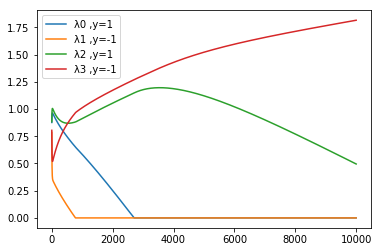

In [20]:
plt.plot(SVM2.lagrange_list1, label="λ0 ,y=1")
plt.plot(SVM2.lagrange_list2, label="λ1 ,y=-1")
plt.plot(SVM2.lagrange_list3, label="λ2 ,y=1")
plt.plot(SVM2.lagrange_list4, label="λ3 ,y=-1")
plt.legend()
plt.show()

## 【問題3〜4】指標値の算出、決定領域の可視化

### Irisデータセットでの検証

In [13]:
#Irisデータセット
from sklearn.datasets import load_iris
iris = load_iris()
nd_Xy  = np.concatenate([iris.data, iris.target.reshape(150,1)], axis=1)

df_0 = pd.DataFrame(nd_Xy, columns=["sepal_length", "sepal_width", "petal_length", "petal_width", "Species"])
df = df_0[df_0["Species"].isin([1, 2])]

df.head()

,sepal_length,sepal_width,petal_length,petal_width,Species
50,7.0,3.2,4.7,1.4,1.0
51,6.4,3.2,4.5,1.5,1.0
52,6.9,3.1,4.9,1.5,1.0
53,5.5,2.3,4.0,1.3,1.0
54,6.5,2.8,4.6,1.5,1.0


In [14]:
#データセット分割
from sklearn.model_selection import train_test_split

X = df.iloc[:,[0,1]].values    #sepal_lengthとsepal_widthのみ選択
y = df["Species"].replace([1,2], [1,-1]).values

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.25, random_state=5,) #シードも設定しておく

print("X_train", np.shape(X_train))
print("X_test", np.shape(X_test))
print("Y_train", np.shape(y_train))
print("Y_test", np.shape(y_test))

X_train (75, 2)
X_test (25, 2)
Y_train (75,)
Y_test (25,)


In [249]:
#標準化処理
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [27]:
#スクラッチで検証
svc = ScratchSVMClassifier(threshold=0.2)
svc.fit(X_train , y_train)
y_pred = svc.predict(X_test)

In [28]:
print(y_pred)

[-1  1  1  1 -1 -1  1  1  1  1 -1 -1 -1  1 -1  1  1 -1  1  1 -1  1 -1  1
 -1]


In [29]:
#スコア
from sklearn import metrics

original_list = [metrics.accuracy_score(y_test, y_pred),
           metrics.precision_score(y_test, y_pred), 
           metrics.recall_score(y_test, y_pred),
           metrics.f1_score(y_test, y_pred) ]

#print("オフィシャル", official_list)
print("スクラッチのスコア　", original_list)

スクラッチのスコア　 [0.76, 0.8571428571428571, 0.75, 0.7999999999999999]


In [55]:
#可視化
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, X_val, y_val, step=0.01,
                    title='decision region',
                    xlabel='xlabel', ylabel='ylabel',
                    target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue',]
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(
        np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step),
        np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step)
    )
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    
    #サポート表示用
    support = np.concatenate([model.sn_, model.yn_.reshape(-1,1)], 1)
    support_df = pd.DataFrame(support, columns=["b", "target1", "target2", "y_train"])
    df_y = support_df[support_df["y_train"] == 1]
    df_my = support_df.query("y_train == -1")

    # plot
    plt.figure(figsize=(12,8))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(
            X[y==target][:, 0],
            X[y==target][:, 1],
            s=80,
            color=scatter_color[i],
            label=target_names[i],
            marker='o')
    for i, target in enumerate(set(y_val)):
        plt.scatter(
            X_val[y_val==target][:, 0],
            X_val[y_val==target][:, 1],
            s=80,
            color=scatter_color[i],
            label=target_names[i],
            marker=',',
            alpha=0.3
        )
    plt.scatter(
        df_y["target1"],
        df_y["target2"],
        s=80,
        color='moccasin',
        label = "supports(1)",
        marker=','
    )
    plt.scatter(
        df_my["target1"],
        df_my["target2"],
        s=80,
        color='#ffff33',
        label = "supports(-1)",
        marker=','
    )
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

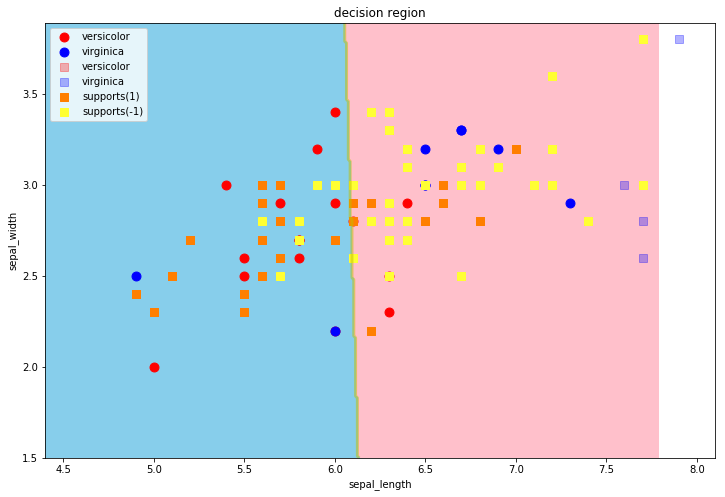

In [41]:
decision_region(X_test, y_test, svc, X_train, y_train, xlabel="sepal_length", ylabel="sepal_width")

### シンプルデータセットでの検証

In [42]:
#シンプルデータセット
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

In [45]:
#分割
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.25, random_state=5,) #シードも設定しておく

print("X_train", np.shape(X_train))
print("X_test", np.shape(X_test))
print("Y_train", np.shape(y_train))
print("Y_test", np.shape(y_test))

X_train (375, 2)
X_test (125, 2)
Y_train (375,)
Y_test (125,)


In [46]:
#標準化処理
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [49]:
#スクラッチで検証
svc = ScratchSVMClassifier(threshold=0.00001)
svc.fit(X_train , y_train)
y_pred = svc.predict(X_test)

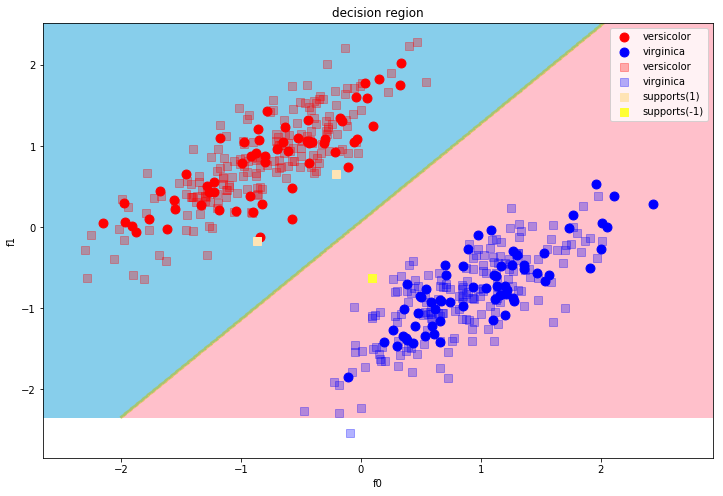

In [56]:
decision_region(X_test, y_test, svc, X_train, y_train, xlabel="f0", ylabel="f1")

## 【問題２】多項式カーネル関数の作成

問題１では、線形カーネルを使用したが、多項式カーネルにも切り替えられるようにする。

「線形カーネルの式」
$$
k(x_i,x_j) = x_i^Tx_j
$$

「多項式カーネルの式」
$$
k(x_i, x_j) = \gamma (x_i^Tx_j + \theta_0)^d
$$

γ、θ０、dはハイパーパラメータ

線形カーネルは、γ＝１、θ０＝０、d＝１の場合の多項式カーネルと等しいと言える

In [72]:
class ScratchSVMClassifier3():
    """
    SVMのスクラッチ実装　更新式をよりシンプルにしたバージョン

    Parameters
    ----------
    num_iter : int　　イテレーション数
    lr : float　　　      学習率
    no_bias : bool      バイアス項を入れない場合はTrue
    verbose : bool     学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : ndarray, shape (n_features,)  パラメータ
    self.loss : ndarray, shape (self.iter,) 　     学習用データに対する損失の記録
    self.val_loss : ndarray, shape (self.iter,)    検証用データに対する損失の記録
    """

    def __init__(self,
                 num_iter=10000,
                 lr=0.001,
                 bias=False,
                 verbose=False,
                 kernel="linear",    #線形カーネル
                 C=1e10,              #ハードマージン
                 threshold=2e-5,
                 polypalam = 0 
                ):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose
        self.kernel = kernel
        self.threshold = threshold
        self.polypalam = polypalam
        #ラグランジュ乗数
        self.lagrange = np.array([])
        self.C = C
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        線形回帰を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)           学習用データの特徴量
        y : ndarray, shape (n_samples, )　　　　　            学習用データの正解値
        X_val : ndarray, shape (n_samples, n_features)     検証用データの特徴量
        y_val : ndarray, shape (n_samples, )　　　            検証用データの正解値
        """
        #サンプル数取得
        smpl_num = X.shape[0]
        
        #バイアス項の生成
        if not self.bias:
            bias_term = np.ones(smpl_num).reshape(smpl_num,1)
            X = np.concatenate([bias_term, X], 1)
        
        #λの初期値
        self.lagrange = np.full(smpl_num, np.random.rand())
        #print("λ初期値=", self.lagrange)
        
        #カーネル関数の生成
        kX = self.kernel_funk(X)
        
        #λ更新
        for _ in range(self.iter):
            self.lagrange += self.lr*(1- np.sum(y.reshape(-1,1)*self.lagrange*y*kX, axis=1))
            self.lagrange = np.where(self.lagrange < 0, 0, self.lagrange)
        
        #サポートベクター
        self.bector_index = np.where(self.lagrange > self.threshold)
        
        self.lagrange_s_ = self.lagrange[self.bector_index]
        self.yn_ = y[self.bector_index]
        self.sn_ = X[self.bector_index]
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
        pass


    def predict(self, X):
        """
        線形回帰を使い推定する。

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)  サンプル

        Returns
        -------
            ndarray, shape (n_samples, 1)   線形回帰による推定結果
        """
        #サンプル数取得
        smpl_num = X_test.shape[0]
        
        #バイアス項の生成
        if not self.bias:
            bias_term = np.ones(smpl_num).reshape(smpl_num,1)
            X_test = np.concatenate([bias_term, X_test], 1)
        
        #推定
        self.y_hat_raw = np.sum(self.lagrange_s_*self.yn_*np.dot(X_test, self.sn_.T), axis=1)
        
        #推定値の変換
        f = lambda x: 1 if x >= 0 else -1
        vf = np.vectorize(f)
        y_hat = vf(self.y_hat_raw)
        
        return y_hat
    
    def kernel_funk(self, X):
        """
        カーネル関数。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        self.polypalam: (gamma, theta, d)

        Returns
        -------
            次の形のndarray, shape (n_samples, n_samples)　カーネル関数
        """
        if self.kernel == "linear":
            k = np.dot(X, X.T)
        elif self.kernel == "poly":
            k = self.polypalam[0](np.dot(X, X.T) + self.polypalam[1])**self.polypalam[2]

        return k


## 【問題５】時間の計測

SVMの学習には時間がかかるため、効率的な実装が望まれる。事前学習期間に行なったように、時間を計測して改善していく。特に 
λ の更新部分は繰り返し処理が多いため、効率的なコードを目指す。

In [ ]:
#雛形

import time
t0 = time.time()
# 何らかの処理
t1 = time.time()
print('time : {}s'.format(t1-t0))

### 改善の記録

1.2章で主にfor文を使用してコーディングを行なった。

テストデータは

X = np.array([[1,1],[5,4], [1,2], [3,4], [2,1], [2,2], [4,3], [5,3]])

y = np.array([1, -1, 1, -1, 1, 1, -1, -1])

と、最小の構成で、イテレーションの回数は1万回だが、その際のfitの時間は

- 1.214981770515442s

となった。上記をベースに、1.2.2章にてfor文を使わないコードに改良。以下、計測時間の記録。

**version1**

ラグランジュ最急降下の箇所にてfor文除去

- 0.5931880474090576s

ラグランジュ値の０未満を０で置換する処理をnp.whereで置き換え

- 0.4944364070892334s

カーネル関数の中のfor文を除去

- 0.5061451911926269s   =>ちょっと上がってしまった

サポートベクターのインデックスを取得するところでnp.whereに置き換え

- 0.5055828332901001s


大きなデータで試してないので、なんとも言えないが、当初のコードと比べるとかなり軽くなった。